# 05. Naive Bayes Classifiers

**Author:** [Your Name/GitHub Username]
**Date:** June 2, 2025

## Introduction

Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying **Bayes' Theorem** with a strong (or "naive") assumption: that the features are conditionally independent given the class.

Despite this simplistic assumption, Naive Bayes classifiers have worked quite well in many real-world situations, especially in text classification (e.g., spam filtering) and medical diagnosis. They are computationally efficient and require a relatively small amount of training data to estimate the necessary parameters.

* **Type:** Supervised Learning
* **Task:** Classification (primarily)
* **Goal:** To determine the probability of a class given a set of features, using Bayes' theorem and the naive independence assumption.

## Theoretical Background

### 1. Bayes' Theorem
Bayes' Theorem describes the probability of an event based on prior knowledge of conditions that might be related to the event. For classification, it's formulated as:

$P(y | X) = \frac{P(X | y) P(y)}{P(X)}$

Where:
* $y$: Class variable (e.g., 'spam', 'not spam').
* $X$: Feature vector ($x_1, x_2, \dots, x_n$).
* $P(y | X)$: **Posterior probability** – The probability of class $y$ given the observed features $X$. This is what we want to calculate.
* $P(X | y)$: **Likelihood** – The probability of observing features $X$ given that the class is $y$.
* $P(y)$: **Prior probability** – The initial probability of class $y$ before observing any features.
* $P(X)$: **Evidence (or Marginal Likelihood)** – The probability of observing features $X$. It acts as a normalizing constant.

For classification, we want to find the class $y$ that maximizes the posterior probability $P(y | X)$. Since $P(X)$ is the same for all classes for a given input $X$, we can simplify this to finding the class $y$ that maximizes $P(X | y) P(y)$.
$\hat{y} = \arg\max_y P(X | y) P(y)$

### 2. The "Naive" Assumption of Conditional Independence
Calculating $P(X | y) = P(x_1, x_2, \dots, x_n | y)$ directly can be complex, especially with many features. The "naive" assumption simplifies this by assuming that all features $x_i$ are conditionally independent of each other, given the class $y$.
This means:
$P(X | y) = P(x_1 | y) \times P(x_2 | y) \times \dots \times P(x_n | y) = \prod_{i=1}^{n} P(x_i | y)$

So, the decision rule becomes:
$\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i | y)$

### 3. Types of Naive Bayes Classifiers
The way $P(x_i | y)$ (the likelihood of a feature given a class) is calculated differs based on the assumed distribution of the features, leading to different types of Naive Bayes classifiers:

* **Gaussian Naive Bayes:**
    * Assumes that continuous features $x_i$ for each class $y$ follow a Gaussian (normal) distribution.
    * $P(x_i | y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right)$
    * The parameters $\mu_y$ (mean) and $\sigma_y^2$ (variance) for each feature $x_i$ and class $y$ are estimated from the training data.
    * Typically used for real-valued numerical features.

* **Multinomial Naive Bayes:**
    * Typically used for discrete features, often representing counts (e.g., word counts in a document).
    * Assumes features are generated from a multinomial distribution.
    * $P(x_i | y)$ is estimated by the frequency of feature $x_i$ appearing in samples belonging to class $y$.
    * Common in text classification.

* **Bernoulli Naive Bayes:**
    * Used for binary/boolean features (i.e., features that are either 0 or 1, representing presence or absence).
    * $P(x_i | y)$ models the probability that feature $x_i$ is present (or absent) given class $y$.
    * Also common in text classification (e.g., using word presence rather than word counts).

### 4. Handling Zero Probabilities (Laplace/Additive Smoothing)
If a particular feature value $x_i$ does not appear in the training set for a given class $y$, its estimated probability $P(x_i | y)$ might become zero. This would cause the entire posterior probability for that class to become zero, which is often undesirable.
**Laplace smoothing** (or additive smoothing) addresses this by adding a small constant $\alpha$ (usually 1) to all counts:
$P(x_i | y) = \frac{\text{count}(x_i, y) + \alpha}{\text{count}(y) + \alpha \cdot N_f}$
where $N_f$ is the number of unique values for feature $x_i$ (or vocabulary size in text). This ensures no probability is exactly zero. Scikit-learn's MultinomialNB and BernoulliNB have an `alpha` parameter for this.

### Pros
* Very fast to train and predict.
* Requires a relatively small amount of training data.
* Performs well even with high-dimensional data (e.g., text).
* Often works well even if the naive independence assumption is violated.
* Provides direct probability estimates.
* Handles both continuous and discrete data (depending on the variant).

### Cons
* The strong naive independence assumption is often not true in real-world data, which can lead to suboptimal performance.
* Can suffer from the zero-frequency problem if not handled with smoothing (for discrete features).
* "Gaussian NB" makes a strong assumption about the distribution of continuous features. If features are not Gaussian, performance may suffer.
* Estimated probabilities are sometimes not well-calibrated (i.e., might be systematically too high or too low, even if the classification is correct).

### Common Use Cases
* Text classification (spam filtering, sentiment analysis, document categorization).
* Medical diagnosis (e.g., predicting disease risk).
* Recommendation systems (as a baseline or component).
* Real-time prediction due to its speed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap # For decision boundary plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # Though NB is less sensitive, let's see its effect
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB # We'll focus on GaussianNB
from sklearn import metrics # For accuracy, confusion matrix, classification report

# Set a style for seaborn plots
sns.set_style('whitegrid')

## Implementation with Python (Gaussian Naive Bayes)

We'll use the **Iris dataset** again for Gaussian Naive Bayes, as its features are continuous. We will use two features for decision boundary visualization.

In [2]:
from sklearn.datasets import load_iris

# Load the dataset
iris = load_iris()

# Use the first two features (sepal length and sepal width) for easier visualization
X = iris.data[:, :2]
y = iris.target

# Create Pandas DataFrames/Series (optional)
X_df = pd.DataFrame(X, columns=iris.feature_names[:2])
y_s = pd.Series(y, name='Target_Class')
target_names = iris.target_names

print("Features (X) - First 5 rows (Sepal Length & Width):")
print(X_df.head())
print(f"\nTarget names: {target_names}")

Features (X) - First 5 rows (Sepal Length & Width):
   sepal length (cm)  sepal width (cm)
0                5.1               3.5
1                4.9               3.0
2                4.7               3.2
3                4.6               3.1
4                5.0               3.6

Target names: ['setosa' 'versicolor' 'virginica']


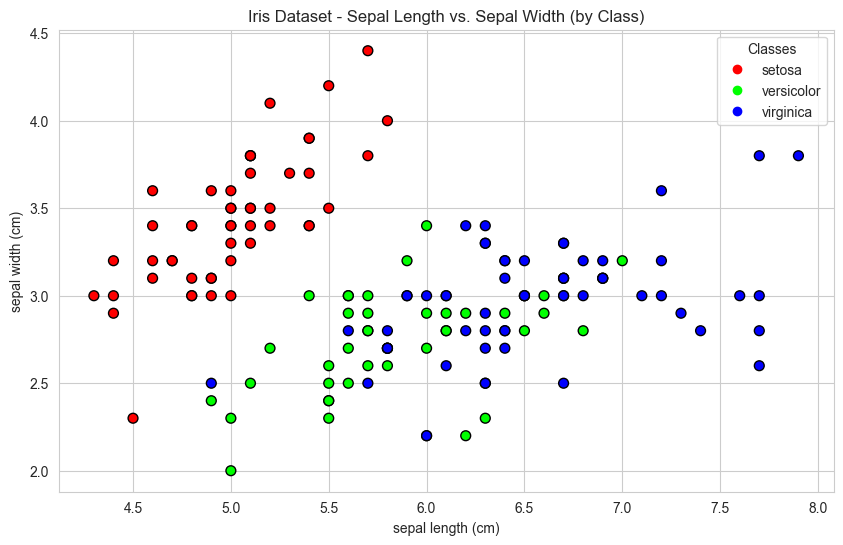

In [3]:
# Visualize the data (same as KNN notebook, for context)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_df.iloc[:, 0], X_df.iloc[:, 1], c=y_s, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']), edgecolor='k', s=50)
plt.title('Iris Dataset - Sepal Length vs. Sepal Width (by Class)')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Classes")
plt.show()

In [4]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_s, test_size=0.3, random_state=42, stratify=y_s)

print(f"Training set size: X_train: {X_train.shape[0]}")
print(f"Testing set size: X_test: {X_test.shape[0]}")

# 2. Feature Scaling (Discussion Point for Naive Bayes)
# Naive Bayes, particularly GaussianNB, calculates probabilities based on the mean and standard deviation
# of each feature within each class. It does not directly use distances like KNN or depend on
# magnitudes for gradient descent like Logistic Regression or SVMs.
# Therefore, feature scaling is generally NOT strictly required or as critical for Naive Bayes.
# However, some argue that features with vastly different scales might lead to numerical
# instability or dominate variance calculations in GaussianNB.
# Let's proceed without scaling first, then optionally try with scaling for comparison.

# For now, no scaling:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Optional: If you wanted to scale
# scaler = StandardScaler()
# X_train_processed = scaler.fit_transform(X_train)
# X_test_processed = scaler.transform(X_test)

Training set size: X_train: 105
Testing set size: X_test: 45


In [5]:
# Create a Gaussian Naive Bayes classifier instance
gnb_classifier = GaussianNB()

# Fit the model (GaussianNB estimates mean and variance for each feature per class)
gnb_classifier.fit(X_train_processed, y_train)

print("Gaussian Naive Bayes classifier trained.")

# You can inspect the learned parameters (class priors, means, variances)
print(f"\nClass Priors (P(y)): {gnb_classifier.class_prior_}")
# print(f"Class Means (theta_): {gnb_classifier.theta_}") # Mean of each feature per class
# print(f"Class Variances (var_): {gnb_classifier.var_}") # Variance of each feature per class

Gaussian Naive Bayes classifier trained.

Class Priors (P(y)): [0.33333333 0.33333333 0.33333333]


In [6]:
# Make predictions on the test set
y_pred_class = gnb_classifier.predict(X_test_processed)
y_pred_proba = gnb_classifier.predict_proba(X_test_processed) # Probabilities for each class

# Display some predictions
predictions_df = pd.DataFrame({
    'Actual Target': y_test.values,
    'Predicted Class': y_pred_class,
    'Prob_Class_0 (Setosa)': y_pred_proba[:, 0],
    'Prob_Class_1 (Versicolor)': y_pred_proba[:, 1],
    'Prob_Class_2 (Virginica)': y_pred_proba[:, 2]
})
print("\nActual vs Predicted classes and Probabilities (first 10):")
print(predictions_df.head(10))


Actual vs Predicted classes and Probabilities (first 10):
   Actual Target  Predicted Class  Prob_Class_0 (Setosa)  \
0              2                2           6.937316e-12   
1              1                1           1.004763e-03   
2              2                1           7.006993e-05   
3              1                2           5.022460e-04   
4              2                1           1.521437e-03   
5              2                2           7.232052e-07   
6              1                1           3.232120e-02   
7              1                1           2.343453e-02   
8              0                0           8.432796e-01   
9              2                2           2.512850e-08   

   Prob_Class_1 (Versicolor)  Prob_Class_2 (Virginica)  
0                   0.046605                  0.953395  
1                   0.662666                  0.336330  
2                   0.626097                  0.373833  
3                   0.236923                  0.7625

### Model Evaluation Metrics (GaussianNB)


Accuracy: 0.6889


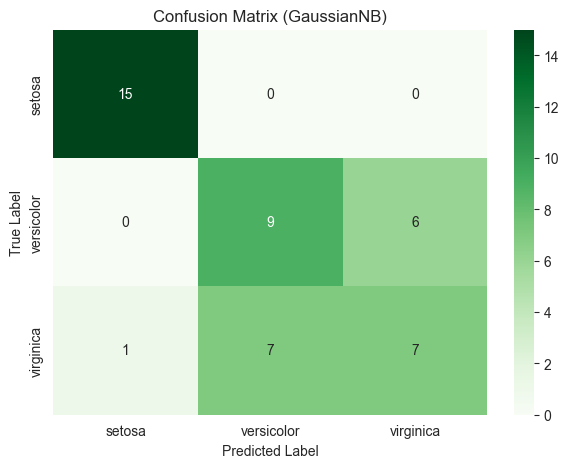


Classification Report:
              precision    recall  f1-score   support

      setosa       0.94      1.00      0.97        15
  versicolor       0.56      0.60      0.58        15
   virginica       0.54      0.47      0.50        15

    accuracy                           0.69        45
   macro avg       0.68      0.69      0.68        45
weighted avg       0.68      0.69      0.68        45



In [7]:
# 1. Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")

# 2. Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (GaussianNB)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. Classification Report
class_report = metrics.classification_report(y_test, y_pred_class, target_names=target_names)
print("\nClassification Report:")
print(class_report)

### Visualizing Decision Boundaries (for 2 features)

/opt/anaconda3/envs/ml_explorer/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


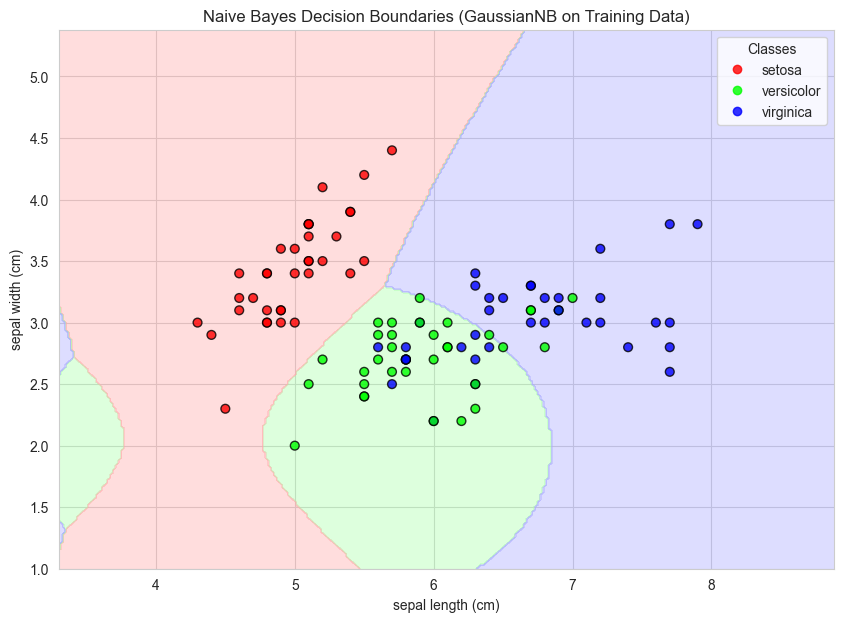

In [8]:
def plot_decision_boundaries_nb(X_data, y_data, model, feature_names, target_names_list, title_suffix=""):
    # Ensure X_data is a NumPy array for indexing
    X_np = X_data.values if isinstance(X_data, pd.DataFrame) else X_data
    y_np = y_data.values if isinstance(y_data, pd.Series) else y_data

    # Create a mesh to plot in
    x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
    y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    plt.figure(figsize=(10, 7))
    custom_cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']) # Light Red, Green, Blue
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap)

    # Plot data points
    scatter_plot = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']), edgecolor='k', s=40, alpha=0.8)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'Naive Bayes Decision Boundaries {title_suffix}')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend(handles=scatter_plot.legend_elements()[0], labels=list(target_names_list), title="Classes")
    plt.show()

# Visualize with the training data points
plot_decision_boundaries_nb(X_train_processed, y_train, gnb_classifier, iris.feature_names[:2], target_names, "(GaussianNB on Training Data)")

The decision boundaries for Gaussian Naive Bayes are typically quadratic (or linear if variances are assumed equal across classes, though scikit-learn's `GaussianNB` doesn't make this specific simplification by default). The shape comes from the intersection of Gaussian probability distributions.

## Other Naive Bayes Variants

While we focused on Gaussian Naive Bayes, it's important to know about other variants:

### 1. Multinomial Naive Bayes (`sklearn.naive_bayes.MultinomialNB`)
* **Use Case:** Primarily for text classification where features represent word counts or term frequencies (TF) or TF-IDF values.
* **Data Type:** Assumes discrete features (e.g., counts of words).
* **Example:** Classifying news articles into categories based on word frequencies.
* **Smoothing:** Uses Laplace/Lidstone smoothing (controlled by `alpha` parameter) to handle words not seen in training for a particular class.

    ```python
    # Conceptual Example for MultinomialNB (not runnable without text data & vectorization)
    # from sklearn.feature_extraction.text import CountVectorizer
    # from sklearn.naive_bayes import MultinomialNB
    #
    # corpus = ['This is the first document.', 'This document is the second document.', 'And this is the third one.']
    # labels = [0, 1, 1] # Example labels
    #
    # vectorizer = CountVectorizer()
    # X_text_counts = vectorizer.fit_transform(corpus)
    #
    # mnb_model = MultinomialNB(alpha=1.0) # alpha for smoothing
    # mnb_model.fit(X_text_counts, labels)
    #
    # new_doc_counts = vectorizer.transform(['This is a new document about something.'])
    # prediction = mnb_model.predict(new_doc_counts)
    # print(f"MultinomialNB prediction for new doc: {prediction}")
    ```

### 2. Bernoulli Naive Bayes (`sklearn.naive_bayes.BernoulliNB`)
* **Use Case:** Also common for text classification, but features are binary (0 or 1), indicating the presence or absence of a term (word).
* **Data Type:** Assumes binary features.
* **Example:** Spam filtering where each feature indicates if a specific keyword is present in an email or not.
* **Smoothing:** Also uses Laplace smoothing (`alpha` parameter).

    ```python
    # Conceptual Example for BernoulliNB
    # (using binary features, perhaps derived from word presence)
    # from sklearn.naive_bayes import BernoulliNB
    #
    # # Example: Features are [feature1_present, feature2_present, ...]
    # X_binary = np.array([[1, 0, 1], [0, 1, 1], [1, 1, 0], [0, 0, 1]]) # Binary features
    # y_binary = np.array([0, 1, 0, 1]) # Example labels
    #
    # bnb_model = BernoulliNB(alpha=1.0)
    # bnb_model.fit(X_binary, y_binary)
    #
    # new_binary_features = np.array([[1, 0, 0]])
    # prediction_bnb = bnb_model.predict(new_binary_features)
    # print(f"BernoulliNB prediction: {prediction_bnb}")
    ```

Choosing the right Naive Bayes variant depends on the nature of your features.

## Conclusion & Key Takeaways

* Naive Bayes classifiers are a group of simple yet effective probabilistic algorithms based on Bayes' Theorem.
* The core "naive" assumption is that features are conditionally independent given the class, which simplifies calculations significantly.
* **GaussianNB** is suitable for continuous numerical features, assuming they follow a Gaussian distribution.
* **MultinomialNB** is designed for discrete count data, widely used in text classification (e.g., word counts).
* **BernoulliNB** works with binary features (e.g., word presence/absence).
* Naive Bayes models are computationally fast, require less training data compared to some complex models, and can handle high-dimensional data well.
* Feature scaling is generally not as critical for Naive Bayes as for distance-based or gradient-based algorithms.
* Despite its simplifying assumptions, Naive Bayes often performs surprisingly well in practice.

## Further Reading/References (Optional)

* [Scikit-learn Naive Bayes Documentation](https://scikit-learn.org/stable/modules/naive_bayes.html)
* Chapter on Naive Bayes in "Pattern Recognition and Machine Learning" by Christopher M. Bishop.
* StatQuest: Naive Bayes, Clearly Explained.